In [1]:
%matplotlib inline
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.utils import save_image
from datetime import datetime
import matplotlib.pyplot as plt
import numpy as np
from tqdm.notebook import tqdm

In [2]:
torch.manual_seed(0)
np.random.seed(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [3]:
from timeit import default_timer
from collections import defaultdict
from tqdm import trange

class Trainer():
    def __init__(self, model, optimizer, loss_f, device, save_dir="results", is_progress_bar=True):
            self.device = device
            self.model = model.to(device)
            self.loss_f = loss_f
            self.optimizer = optimizer
            self.save_dir = save_dir
            self.is_progress_bar = is_progress_bar
            
    def __call__(self, data_loader, epochs=10, checkpoint_every=10):
        start = default_timer()
        self.model.train()
        for epoch in range(epochs):
            storer = defaultdict(list)
            mean_epoch_loss = self._train_epoch(data_loader, storer, epoch)
            mean_epoch_loss = self._test_epoch(data_loader, storer, epoch)
            with torch.no_grad():
                sample = torch.randn(64, self.model.latent_dim).to(device)
                sample = self.model.decoder(sample).cpu()  # make sure on cpu
                save_image(sample.view(64, 1, 32, 32),
                           './results/samples/' + str(epoch) + '.png')
            
    def _train_epoch(self, data_loader, storer, epoch):
        epoch_loss = 0.
        kwargs = dict(desc="Epoch {}".format(epoch + 1), leave=False,
                      disable=not self.is_progress_bar)
        with trange(len(data_loader), **kwargs) as t:
            for _, (data, _) in enumerate(data_loader):
                iter_loss = self._train_iteration(data, storer)
                epoch_loss += iter_loss
                t.set_postfix(loss=iter_loss)
                t.update()
        mean_epoch_loss = epoch_loss / len(data_loader)
        return mean_epoch_loss
    
    def _train_iteration(self, data, storer):
        batch_size, channel, height, width = data.size()
        data = data.to(self.device)
        recon_batch, latent_dist, latent_sample = self.model(data)
        loss = self.loss_f(data, recon_batch, latent_dist, self.model.training, 
                           storer, latent_sample=latent_sample)
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
            
        return loss.item()
    
    def _test_epoch(self, data_loader, storer, epoch):
        epoch_loss = 0.
        kwargs = dict(desc="Epoch {}".format(epoch + 1), leave=False,
                      disable=not self.is_progress_bar)
        with trange(len(data_loader), **kwargs) as t:
            for _, (data, _) in enumerate(data_loader):
                iter_loss = self._train_iteration(data, storer)
                epoch_loss += iter_loss
                t.set_postfix(loss=iter_loss)
                t.update()
        mean_epoch_loss = epoch_loss / len(data_loader)
        return mean_epoch_loss
    
    def _test_iteration(self, data, storer):
        batch_size, channel, height, width = data.size()
        data = data.to(self.device)
        recon_batch, latent_dist, latent_sample = self.model(data)
        loss = self.loss_f(data, recon_batch, latent_dist, self.model.training, 
                               storer, latent_sample=latent_sample)
            
        return loss.item()

In [4]:
LOSSES = ["betaH", "betaB"]
RECON_DIST = ["bernoulli", "laplace", "gaussian"]

In [5]:
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision import transforms

batch_size = 64

mnist_dataset = datasets.MNIST('/home/data/bvaa', 
                   train=True, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

mnist_dataset_test = datasets.MNIST('/home/data/bvaa', train=False, download=True, transform=transforms.Compose([
                       transforms.Resize(32),
                       transforms.ToTensor()
                   ]))

train_loader = DataLoader(mnist_dataset, batch_size=batch_size, shuffle=True)

test_loader = DataLoader(mnist_dataset_test, batch_size=batch_size, shuffle=True)

In [6]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [7]:
from vae import VAE
from encoder import Encoder
from decoder import Decoder
from losses import get_loss_fn
from torch import optim

latent_dim = 12
img_size = [1,32,32]

lr = 5e-4

betaB_args = {"rec_dist": "bernoulli",
              "reg_anneal": 10000, 
              "betaH_B": 4,
              "betaB_initC": 0,
              "betaB_finC": 25,
              "betaB_G": 100
             }

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_f = get_loss_fn("betaB", n_data=len(train_loader.dataset), device=device, **betaB_args)

encoder = Encoder(img_size, latent_dim)
decoder = Decoder(img_size, latent_dim)

generator_model = VAE(img_size, latent_dim, encoder, decoder).to(device)
optimizer = optim.Adam(generator_model.parameters(), lr=lr)

In [8]:
# trainer = Trainer(generator_model, optimizer, loss_f, device, logger=logger,\
#                   save_dir=exp_dir, is_progress_bar=False)
# epochs = 100
# checkpoint_every = 10
# trainer(train_loader, epochs=epochs, checkpoint_every=checkpoint_every)
# torch.save(trainer.model.state_dict(), 'test.pt')

In [9]:
generator_model.load_state_dict(torch.load('models/test.pt'))
# generator_model.eval()

<All keys matched successfully>

In [10]:
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout2d(0.25)
        self.dropout2 = nn.Dropout2d(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.softmax(x, dim=1)
        return output

classifier = Classifier()
classifier.load_state_dict(torch.load('models/mnist_cnn_non_log.pt'))

<All keys matched successfully>

In [11]:
class AddNoise():
    def __init__(self, shape, device, noise=None, percent_noise=0.1):
        self.device = device
        self.percent_noise = percent_noise
        if noise is None:
            self.noise = torch.randn(shape)
        else:
            self.noise = noise

    def noisy(self, data):
        x = self.noise.to(self.device) * self.percent_noise + data * (1 - self.percent_noise)
        return x

In [12]:
sample_noise = torch.randn(torch.Size([1, 12]))
backup_sample_noise = sample_noise
print("Sample Noise for Testing: \n", sample_noise)

Sample Noise for Testing: 
 tensor([[ 0.7344,  0.0049,  0.1108, -0.9742,  0.7806,  0.4000, -0.6167, -1.0133,
          0.4483, -0.2564, -0.7429,  0.7341]])


In [13]:
decoder = generator_model.decoder
decoder.eval()

Decoder(
  (lin1): Linear(in_features=12, out_features=256, bias=True)
  (lin2): Linear(in_features=256, out_features=256, bias=True)
  (lin3): Linear(in_features=256, out_features=512, bias=True)
  (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (convT3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
)

In [14]:
classifier.eval()

Classifier(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout2d(p=0.25, inplace=False)
  (dropout2): Dropout2d(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

In [15]:
from math import exp

def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()

def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = torch.Tensor(_2D_window.expand(channel, 1, window_size, window_size).contiguous())
    return window

def _ssim(img1, img2, window, window_size, channel, size_average = True):
    mu1 = F.conv2d(img1, window, padding = window_size//2, groups = channel)
    mu2 = F.conv2d(img2, window, padding = window_size//2, groups = channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding = window_size//2, groups = channel) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding = window_size//2, groups = channel) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding = window_size//2, groups = channel) - mu1_mu2

    C1 = 0.01**2
    C2 = 0.03**2

    ssim_map = ((2*mu1_mu2 + C1)*(2*sigma12 + C2))/((mu1_sq + mu2_sq + C1)*(sigma1_sq + sigma2_sq + C2))

    if size_average:
        return ssim_map.mean()
    else:
        return ssim_map.mean(1).mean(1).mean(1)

class SSIM(nn.Module):
    def __init__(self, window_size = 11, size_average = True):
        super(SSIM, self).__init__()
        self.window_size = window_size
        self.size_average = size_average
        self.channel = 1
        self.window = create_window(window_size, self.channel)

    def forward(self, img1, img2):
        (_, channel, _, _) = img1.size()

        if channel == self.channel and self.window.data.type() == img1.data.type():
            window = self.window
        else:
            window = create_window(self.window_size, channel)
            
            if img1.is_cuda:
                window = window.cuda(img1.get_device())
            window = window.type_as(img1)
            
            self.window = window
            self.channel = channel


        return _ssim(img1, img2, window, self.window_size, channel, self.size_average)

def ssim(img1, img2, window_size = 11, size_average = True):
    (_, channel, _, _) = img1.size()
    window = create_window(window_size, channel)
    
    if img1.is_cuda:
        window = window.cuda(img1.get_device())
    window = window.type_as(img1)
    
    return _ssim(img1, img2, window, window_size, channel, size_average)

ssim_loss = SSIM(window_size = 5)

In [16]:
# Constrained Translator
class Translator(nn.Module):
    def __init__(self, hidden_layers=[5, 10, 5], latent_dim=latent_dim):
        super(Translator, self).__init__()
        self.hidden_layers = hidden_layers
        self.hidden_layers.insert(0, latent_dim)
        self.hidden_layers.append(latent_dim)
        self.layers = []
        
        for i in range(len(self.hidden_layers)-1):
            self.layers.append(nn.Linear(self.hidden_layers[i], self.hidden_layers[i+1]))
        
        self.layers = nn.ModuleList(self.layers)
        
    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        
        return x

translator = Translator().to(device)

In [17]:
# from skimage.metrics import structural_similarity as ssim

def create_logits(target_label, pred, confidence=0.53, device=device):
    logits = torch.zeros(pred.shape, dtype=torch.float64)
    pred_labels = [int(element.item()) for element in torch.argmax(pred, dim=1)]
#     print("length", len(pred_labels))
#     print("pred_lables:",pred_labels)
#     print(logits.shape)
    logits[range(logits.shape[0]), pred_labels] = torch.DoubleTensor([1-confidence]*pred.shape[0])
    logits[range(logits.shape[0]), [target_label]*pred.shape[0]] += torch.DoubleTensor([confidence]*pred.shape[0])
#     print("logits:", logits)
    return logits.to(device)

def structural(org_image, noised_image):
    batch_size, channels, width, height = org_image.shape
    loss1 = 0
    for b_ in range(batch_size):
        ch_loss = 0
        for ch_ in range(channels):
            ch_loss += 1-ssim(org_image[b_][ch_].detach().cpu().numpy(), noised_image[b_][ch_].detach().cpu().numpy())
        loss1 += ch_loss/channels
    return loss1
            
class T_Loss(nn.Module):
    def __init__(self, decoder=decoder, classifier=classifier):
        super(T_Loss, self).__init__()
        self.decoder = decoder
        self.classifier = classifier
    def forward(self, x, org_x, target_label):
        
        org_image = self.decoder(org_x)
        noised_image = self.decoder(x)
        batch_size, channels, width, height = org_image.shape
        loss1 = ssim_loss(org_image, noised_image)
#         print(type(loss1))
#         print(loss1)
#         loss1 = torch.Tensor(loss1 / batch_size).to(device)
#         print("loss1:", loss1)
        preds = self.classifier(F.upsample(noised_image, (28,28), mode='bilinear', align_corners=True))
#         print("preds:",preds)
        target = create_logits(target_label, preds)
#         print(target)
        loss2 = nn.BCELoss(reduction='sum')(preds, target.float())
#         print(type(loss2))
#         print("loss1:",100*(1-loss1))
#         print("loss2:",loss2)
        loss = 100*(1-loss1) + loss2
        
        
        out_labels = preds.argmax(dim=1, keepdim=True)
#         print(out_labels)
#         print(torch.empty(out_labels.shape).fill_(target_label))
#         print(preds)
#         correct = out_labels.eq(torch.Tensor([target_label]*out_labels.shape[0]).to(device)).sum()
        correct = out_labels.eq(torch.empty(out_labels.shape).fill_(target_label).to(device)).sum()
#         print(out_labels.shape)
#         print(correct)
#         print(torch.Tensor([target_label]*out_labels.shape[0]))
#         print(out_labels)
        return loss, correct.item()

In [18]:
tloss = T_Loss().to(device)
tloss.eval()

T_Loss(
  (decoder): Decoder(
    (lin1): Linear(in_features=12, out_features=256, bias=True)
    (lin2): Linear(in_features=256, out_features=256, bias=True)
    (lin3): Linear(in_features=256, out_features=512, bias=True)
    (convT1): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT2): ConvTranspose2d(32, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (convT3): ConvTranspose2d(32, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  )
  (classifier): Classifier(
    (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (dropout1): Dropout2d(p=0.25, inplace=False)
    (dropout2): Dropout2d(p=0.5, inplace=False)
    (fc1): Linear(in_features=9216, out_features=128, bias=True)
    (fc2): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [19]:
len(train_loader)

938

In [20]:
attack_log_interval = 1
alt_target = 5
translator.train()
optimizer = optim.Adam(translator.parameters(), lr=1e-3)
for epoch in tqdm(range(10)):
    epoch_loss = 0
    epoch_correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data = torch.FloatTensor(data).to(device)
        
        _, l_dist, l_sample = generator_model(data)
        
        noised_sample = translator(l_sample)
        
        loss, correct = tloss(noised_sample, l_sample, alt_target)
        loss.backward()
        optimizer.step()
#         print(correct)
        epoch_loss += loss.item()
        epoch_correct += correct
        
    if (epoch+1) % attack_log_interval == 0:
        print('Train Epoch: {}\tLoss: {:.6f}\tCorrect: {}'.format(
            epoch, epoch_loss/batch_idx, epoch_correct))

/opt/miniconda3/envs/bvaa/lib/python3.6/site-packages/torch/nn/functional.py:2416: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")


Train Epoch: 0	Loss: 248.810912	Correct: 14341
Train Epoch: 1	Loss: 216.653952	Correct: 12383
Train Epoch: 2	Loss: 197.100085	Correct: 15052
Train Epoch: 3	Loss: 117.496681	Correct: 54548
Train Epoch: 4	Loss: 107.915900	Correct: 59697
Train Epoch: 5	Loss: 101.067268	Correct: 59687
Train Epoch: 6	Loss: 103.113236	Correct: 59961
Train Epoch: 7	Loss: 109.307953	Correct: 59579
Train Epoch: 8	Loss: 108.893671	Correct: 58294
Train Epoch: 9	Loss: 110.440082	Correct: 59287



In [21]:
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [22]:
def test(i, conf):
    _, l_dist, l_sample = generator_model(example_data[i].unsqueeze_(0).to(device))
    noised_sample = translator(l_sample)
    noised_sample = conf * l_sample + (1-conf) * (noised_sample - noised_sample.min())/(noised_sample.max() - noised_sample.min())
    final = generator_model.decoder(noised_sample)
    pred = torch.argmax(classifier(F.upsample(final, (28,28), mode='bilinear', align_corners=True)))
    print("Actual: {}, Prediction: {}".format(example_targets[i], pred.item()))
    plt.figure(figsize=(10,10))
    plt.subplot(1,2,1)
    plt.imshow(example_data[i][0].detach().cpu().numpy(), cmap='gray', interpolation='none')
    plt.subplot(1,2,2)
    plt.imshow(final[0][0].detach().cpu().numpy(), cmap='gray', interpolation='none')

Actual: 5, Prediction: 5


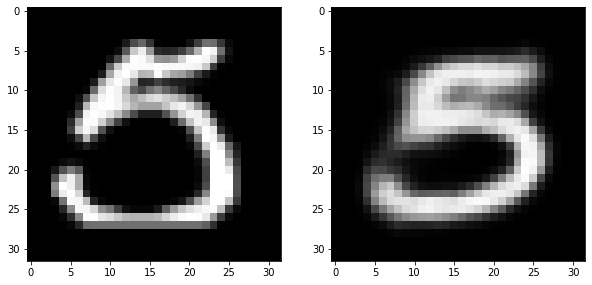

In [49]:
test(49, 0.6909)